In [1]:
import re
import sys
import pickle
import numpy as np

import dgl
from dgl.data import DGLDataset
from dgl.nn.pytorch import SumPooling, AvgPooling

import math
import time

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingWarmRestarts, _LRScheduler

from einops import repeat, rearrange

from utils import get_seed, get_num_params, plot_heatmap

from tqdm import tqdm
from sparsemax import Sparsemax

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import matplotlib.pyplot as plt

print(torch.__version__)

2.2.0


In [2]:
'''
    A simple MLP class, includes at least 2 layers and n hidden layers
'''
class MLP(nn.Module):
    def __init__(self, n_input, n_hidden, n_output, n_layers=1, act=nn.GELU()):
        super(MLP, self).__init__()

        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.n_layers = n_layers
        self.linear_pre = nn.Linear(n_input, n_hidden)
        self.linear_post = nn.Linear(n_hidden, n_output)
        self.linears = nn.ModuleList([nn.Linear(n_hidden, n_hidden) for _ in range(n_layers)])
        self.act = act
        # self.bns = nn.ModuleList([nn.BatchNorm1d(n_hidden) for _ in range(n_layers)])


    def forward(self, x):
        x = self.act(self.linear_pre(x))
        for i in range(self.n_layers):
            x = x + self.act(self.linears[i](x))
            # x = x + self.act(self.bns[i](self.linears[i](x)))

        x = self.linear_post(x)
        return x

In [3]:
class GPTConfig():
    """ base GPT config, params common to all GPT versions """
    def __init__(self,
                 attn_type      ='linear',
                 embd_pdrop     =0.0,
                 resid_pdrop    =0.0,
                 attn_pdrop     =0.0,
                 n_embd         =128,
                 n_head         =2,
                 n_layer        =3,
                 n_inner        =4,
                 act            =nn.GELU(),
                 branch_sizes   =1,
                 n_inputs       =1,
                 n_experts      =2,
                 space_dim      =1,
                 ):
        
        self.attn_type      = attn_type  
        self.embd_pdrop     = embd_pdrop
        self.resid_pdrop    = resid_pdrop
        self.attn_pdrop     = attn_pdrop
        self.n_embd         = n_embd
        self.n_head         = n_head
        self.n_layer        = n_layer
        self.n_inner        = n_inner * self.n_embd
        self.act            = act
        self.n_experts      = n_experts
        self.branch_sizes   = branch_sizes
        self.n_inputs       = n_inputs
        self.space_dim      = space_dim

In [4]:
### x: list of tensors
class MultipleTensors():
    def __init__(self, x):
        self.x = x

    def to(self, device):
        self.x = [x_.to(device) for x_ in self.x]
        return self

    def __len__(self):
        return len(self.x)


    def __getitem__(self, item):
        return self.x[item]

In [5]:
def generalized_kernel(data, *, projection_matrix, kernel_fn = nn.ReLU(), kernel_epsilon = 0.001, normalize_data = True, device = None):
    b, h, *_ = data.shape

    data_normalizer = (data.shape[-1] ** -0.25) if normalize_data else 1.

    if projection_matrix is None:
        return kernel_fn(data_normalizer * data) + kernel_epsilon

    projection = repeat(projection_matrix, 'j d -> b h j d', b = b, h = h)
    projection = projection.type_as(data)

    data_dash = torch.einsum('...id,...jd->...ij', (data_normalizer * data), projection)

    data_prime = kernel_fn(data_dash) + kernel_epsilon
    return data_prime.type_as(data)

### 사용예시 ###

# 데이터셋 생성
data = torch.randn(2, 6, 4, 5)  # 배치 크기: 2, 특징 차원: 1, 나머지 차원: (4, 5)

# 프로젝션 매트릭스 생성 (임의의 고차원 투영)
projection_matrix = torch.randn(5, 5)

# 함수 호출
result = generalized_kernel(data, projection_matrix=projection_matrix)
print("Transformed Data Shape:", result.shape)

# 유사성 측정
similarity = F.cosine_similarity(result[0], result[1], dim=0)
print("Cosine Similarity between the two samples in the batch:", similarity)

Transformed Data Shape: torch.Size([2, 6, 4, 5])
Cosine Similarity between the two samples in the batch: tensor([[0.5900, 0.0035, 1.0000, 0.3822, 0.6452],
        [0.8954, 0.0031, 0.1729, 0.3568, 0.4939],
        [0.3365, 0.7436, 0.0388, 0.1777, 0.8608],
        [0.2412, 0.4620, 0.0024, 0.4368, 0.5143]])


In [6]:
def orthogonal_matrix_chunk(cols, device = None):
    from distutils.version import LooseVersion
    TORCH_GE_1_8_0 = LooseVersion(torch.__version__) >= LooseVersion('1.8.0')
    unstructured_block = torch.randn((cols, cols), device = device)
    if TORCH_GE_1_8_0:
        q, r = torch.linalg.qr(unstructured_block.cpu(), mode = 'reduced')
    else:
        q, r = torch.qr(unstructured_block.cpu(), some = True)
    q, r = map(lambda t: t.to(device), (q, r))
    return q.t()

orthogonal_matrix = orthogonal_matrix_chunk(5, device='cpu')
print("Orthogonal Matrix:")
print(orthogonal_matrix)

# 생성된 직교 행렬의 특성 검증
# 직교 행렬과 그 전치의 곱은 단위 행렬(identity matrix)이어야 합니다.
identity_approx = torch.mm(orthogonal_matrix, orthogonal_matrix.t())

print("Identity Matrix Approximation:")
print(identity_approx)

Orthogonal Matrix:
tensor([[-0.4482, -0.0060,  0.7484, -0.0703,  0.4838],
        [ 0.4317, -0.0381,  0.1767,  0.8478,  0.2493],
        [ 0.1224, -0.9761, -0.0219, -0.1356,  0.1155],
        [ 0.3573, -0.0325,  0.6370, -0.1185, -0.6719],
        [ 0.6857,  0.2113,  0.0500, -0.4937,  0.4888]])
Identity Matrix Approximation:
tensor([[ 1.0000e+00,  2.0087e-08, -3.8856e-09, -1.2433e-08,  2.2281e-08],
        [ 2.0087e-08,  1.0000e+00, -1.0655e-07,  1.9881e-08, -1.5908e-08],
        [-3.8856e-09, -1.0655e-07,  1.0000e+00,  6.1755e-08,  4.4201e-08],
        [-1.2433e-08,  1.9881e-08,  6.1755e-08,  1.0000e+00,  2.9307e-08],
        [ 2.2281e-08, -1.5908e-08,  4.4201e-08,  2.9307e-08,  1.0000e+00]])


C:\Users\enomazosii\AppData\Local\Temp\ipykernel_9740\2552538928.py:3: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  TORCH_GE_1_8_0 = LooseVersion(torch.__version__) >= LooseVersion('1.8.0')


In [7]:
'''
    X: N*T*C --> N*(4*n + 3)*C 
'''
def horizontal_fourier_embedding(X, n=3):
    freqs = 2**torch.linspace(-n, n, 2*n+1).to(X.device)
    freqs = freqs[None,None,None,...]
    X_ = X.unsqueeze(-1).repeat([1,1,1,2*n+1])
    X_cos = torch.cos(freqs * X_)
    X_sin = torch.sin(freqs * X_)
    X = torch.cat([X.unsqueeze(-1), X_cos, X_sin],dim=-1).view(X.shape[0],X.shape[1],-1)
    return X

In [8]:
class LinearAttention(nn.Module):
    
    def __init__(self, config):
        super(LinearAttention, self).__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads
        self.key = nn.Linear(config.n_embd, config.n_embd)
        self.query = nn.Linear(config.n_embd, config.n_embd)
        self.value = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_drop = nn.Dropout(config.attn_pdrop)
        # output projection
        self.proj = nn.Linear(config.n_embd, config.n_embd)

        self.n_head = config.n_head

        self.attn_type = 'l1'

    '''
        Linear Attention and Linear Cross Attention (if y is provided)
    '''
    def forward(self, x, y=None, layer_past=None):
        y = x if y is None else y
        B, T1, C = x.size()
        _, T2, _ = y.size()
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q = self.query(x).view(B, T1, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        k = self.key(y).view(B, T2, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        v = self.value(y).view(B, T2, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)


        if self.attn_type == 'l1':
            q = q.softmax(dim=-1)
            k = k.softmax(dim=-1)   #
            k_cumsum = k.sum(dim=-2, keepdim=True)
            D_inv = 1. / (q * k_cumsum).sum(dim=-1, keepdim=True)       # normalized
        elif self.attn_type == "galerkin":
            q = q.softmax(dim=-1)
            k = k.softmax(dim=-1)  #
            D_inv = 1. / T2                                           # galerkin
        elif self.attn_type == "l2":                                   # still use l1 normalization
            q = q / q.norm(dim=-1,keepdim=True, p=1)
            k = k / k.norm(dim=-1,keepdim=True, p=1)
            k_cumsum = k.sum(dim=-2, keepdim=True)
            D_inv = 1. / (q * k_cumsum).abs().sum(dim=-1, keepdim=True)  # normalized
        else:
            raise NotImplementedError

        context = k.transpose(-2, -1) @ v
        y = self.attn_drop((q @ context) * D_inv + q)

        # output projection
        y = rearrange(y, 'b h n d -> b n (h d)')
        y = self.proj(y)
        return y
    
class LinearCrossAttention(nn.Module):

    def __init__(self, config):
        super(LinearCrossAttention, self).__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads
        self.query = nn.Linear(config.n_embd, config.n_embd)
        self.keys = nn.ModuleList([nn.Linear(config.n_embd, config.n_embd) for _ in range(config.n_inputs)])
        self.values = nn.ModuleList([nn.Linear(config.n_embd, config.n_embd) for _ in range(config.n_inputs)])
        # regularization
        self.attn_drop = nn.Dropout(config.attn_pdrop)
        # output projection
        self.proj = nn.Linear(config.n_embd, config.n_embd)

        self.n_head = config.n_head
        self.n_inputs = config.n_inputs

        self.attn_type = 'l1'

    '''
        Linear Attention and Linear Cross Attention (if y is provided)
    '''
    def forward(self, x, ys=None, layer_past=None):
        if ys is None:
            ys = [x] * self.n_inputs
        B, T1, C = x.size()
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q = self.query(x).view(B, T1, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        q = q.softmax(dim=-1)
        out = torch.zeros_like(q)
        for i, y in enumerate(ys):
            _, T2, _ = y.size()
            k = self.keys[i](y).view(B, T2, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
            v = self.values[i](y).view(B, T2, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
            k = k.softmax(dim=-1)
            k_cumsum = k.sum(dim=-2, keepdim=True)
            D_inv = 1. / (q * k_cumsum).sum(dim=-1, keepdim=True)  # normalized
            out += (q @ (k.transpose(-2, -1) @ v)) * D_inv

        # Apply dropout to the combined attention output before projection
        out = self.attn_drop(out)

        # output projection
        projected_output = rearrange(out, 'b h n d -> b n (h d)')
        projected_output = self.proj(projected_output)

        # Residual connection
        output = x + projected_output  # Add original input x to the output of the projection

        return output


In [9]:
class LinformerAttention(nn.Module):
    def __init__(self, n_channels, k=64):
        super().__init__()
        self.proj_k = nn.Linear(n_channels, k)
        self.proj_v = nn.Linear(n_channels, k)

    def forward(self, x):
        k = self.proj_k(x)
        v = self.proj_v(x)
        weights = torch.einsum('bhd,bhe->bde', x, k)
        return torch.einsum('bde,bhd->bhe', weights.softmax(dim=-1), v)

class Net(nn.Module):
    def init(self,
             state_size,
             n_embd=32,
             action_space=3
             ):
        super(Net, self).init()
        self.ln1         = nn.LayerNorm(n_embd)
        self.ln2         = nn.LayerNorm(n_embd)
        self.ln3         = nn.LayerNorm(n_embd)
        self.ln4         = nn.LayerNorm(n_embd)
        self.ln5         = nn.LayerNorm(n_embd)

        self.attn1       = LinformerAttention(n_channels=n_embd)
        self.attn2       = LinformerAttention(n_channels=n_embd)
        self.resid_drop1 = nn.Dropout(0.1)
        self.resid_drop2 = nn.Dropout(0.1) # Dropout 빼려면 0

        self.linear1     = nn.Sequential(
            nn.Linear(state_size, n_embd),
            nn.RELU(), # nn.GELU() 추천
        )
        self.linear2     = nn.Sequential(
            nn.Linear(n_embd, n_embd),
            nn.RELU(),
        )

        self.linear3    = nn.Sequential(
            nn.Linear(n_embd, action_space),
            nn.RELU(),
        )

    def forward(self, x):
        x = x + self.linear1(self.ln1(x)) # residual 빼려면 x+ 를 뺴면됩니다.
        x = x + self.resid_drop1(self.attn1(self.ln2(x)))
        x = x + self.linear2(self.ln3(x))
        x = x + self.resid_drop2(self.attn2(self.ln4(x)))
        x = x + self.linear3(self.ln5(x))
        return x

In [10]:
'''
    Self and Cross Attention block for CGPT, contains  a cross attention block and a self attention block
'''
class MIOECrossAttentionBlock(nn.Module):
    def __init__(self, config):
        super(MIOECrossAttentionBlock, self).__init__()
        self.ln1            = nn.LayerNorm(config.n_embd)
        self.ln2_branch     = nn.ModuleList([
            nn.LayerNorm(config.n_embd) for _ in range(config.n_inputs)
            ])
        self.ln3            = nn.LayerNorm(config.n_embd)
        self.ln4            = nn.LayerNorm(config.n_embd)
        self.ln5            = nn.LayerNorm(config.n_embd)

        self.selfattn       = LinearAttention(config)
        self.crossattn      = LinearCrossAttention(config)
        # self.selfattn_branch= LinearAttention(config)
        
        self.resid_drop1    = nn.Dropout(config.resid_pdrop)
        self.resid_drop2    = nn.Dropout(config.resid_pdrop)
        self.n_experts      = config.n_experts
        self.n_inputs       = config.n_inputs
        self.act            = config.act
        self.sparsemax      = Sparsemax(dim=-1)
        
        self.moe_mlp1 = nn.ModuleList([nn.Sequential(
            nn.Linear(config.n_embd, config.n_inner),
            self.act,
            nn.Linear(config.n_inner, config.n_embd),
        ) for _ in range(self.n_experts)])

        self.moe_mlp2 = nn.ModuleList([nn.Sequential(
            nn.Linear(config.n_embd, config.n_inner),
            self.act,
            nn.Linear(config.n_inner, config.n_embd),
        ) for _ in range(self.n_experts)])

        self.gatenet = nn.Sequential(
            nn.Linear(config.space_dim, config.n_inner),
            self.act,
            nn.Linear(config.n_inner, config.n_inner),
            self.act,
            nn.Linear(config.n_inner, self.n_experts)
        )

    def ln_branchs(self, y):
        return MultipleTensors([self.ln2_branch[i](y[i]) for i in range(self.n_inputs)])
    '''
        x: [B, T1, C], y:[B, T2, C], pos:[B, T1, n]
    '''
    def forward(self, x, y, pos):
        gate_score = F.softmax(self.gatenet(pos), dim=-1).unsqueeze(2)    # B, T1, 1, m
        x = x + self.resid_drop1(self.crossattn(self.ln1(x), self.ln_branchs(y)))
        x_moe1 = torch.stack([self.moe_mlp1[i](x) for i in range(self.n_experts)],dim=-1) # B, T1, C, m
        x_moe1 = (gate_score*x_moe1).sum(dim=-1,keepdim=False)
        x = x + self.ln3(x_moe1)
        x = x + self.resid_drop2(self.selfattn(self.ln4(x)))
        x_moe2 = torch.stack([self.moe_mlp2[i](x) for i in range(self.n_experts)],dim=-1) # B, T1, C, m
        x_moe2 = (gate_score*x_moe2).sum(dim=-1,keepdim=False)
        x = x + self.ln5(x_moe2)
        return x

In [11]:
class GNOT(nn.Module):
    def __init__(self,
                 trunk_size         = 2,
                 branch_sizes       = None,
                 space_dim          = 2,
                 output_size        = 3,
                 n_layers           = 2,
                 n_hidden           = 64,
                 n_head             = 1,
                 n_experts          = 2,
                 n_inner            = 4,
                 mlp_layers         = 2,
                 attn_type          = 'linear',
                 act                = 'gelu',
                 ffn_dropout        = 0.0,
                 attn_dropout       = 0.0,
                 horiz_fourier_dim  = 0,
                 ):
        super(GNOT, self).__init__()
        
        self.__name__ = 'GNOT'
        self.gpt_config = GPTConfig(
            attn_type   = attn_type,
            embd_pdrop  = ffn_dropout,
            resid_pdrop = ffn_dropout,
            attn_pdrop  = attn_dropout,
            n_embd      = n_hidden,
            n_head      = n_head,
            n_layer     = n_layers,
            act         = act,
            n_experts   = n_experts,
            space_dim   = space_dim, 
            branch_sizes= branch_sizes,
            n_inputs    = len(branch_sizes),
            n_inner     = n_inner
            )

        self.horiz_fourier_dim  = horiz_fourier_dim
        self.trunk_size         = trunk_size * (4*horiz_fourier_dim + 3) if horiz_fourier_dim>0 else trunk_size
        self.branch_sizes       = [bsize * (4*horiz_fourier_dim + 3) for bsize in branch_sizes] if horiz_fourier_dim > 0 else branch_sizes
        self.n_inputs           = len(self.branch_sizes)
        self.output_size        = output_size
        self.space_dim          = space_dim

        self.trunk_mlp      = MLP(self.trunk_size, n_hidden, n_hidden, n_layers=mlp_layers,act=act)
        self.branch_mlps    = nn.ModuleList([MLP(bsize, n_hidden, n_hidden, n_layers=mlp_layers,act=act) for bsize in self.branch_sizes])
        self.blocks         = nn.Sequential(*[MIOECrossAttentionBlock(self.gpt_config) for _ in range(self.gpt_config.n_layer)])
        self.out_mlp        = MLP(n_hidden, n_hidden, output_size, n_layers=mlp_layers)

        # self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.0002)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)



    def forward(self, g, u_p, inputs):
        gs = dgl.unbatch(g)
        x = pad_sequence([_g.ndata['x'] for _g in gs]).permute(1, 0, 2)  # B, T1, F

        pos = x[:,:,0:self.space_dim]


        x = torch.cat([x, u_p.unsqueeze(1).repeat([1, x.shape[1], 1])], dim=-1)

        # if self.horiz_fourier_dim > 0:
        #     x = horizontal_fourier_embedding(x, self.horiz_fourier_dim)
        #     z = horizontal_fourier_embedding(z, self.horiz_fourier_dim)

        x = self.trunk_mlp(x)
        z = MultipleTensors([self.branch_mlps[i](inputs[i]) for i in range(self.n_inputs)])

        for block in self.blocks:
            x = block(x, z, pos)
        x = self.out_mlp(x)

        x_out = torch.cat([x[i, :num] for i, num in enumerate(g.batch_num_nodes())],dim=0)
        return x_out

In [12]:
'''
    Simple normalization layer
'''
class UnitTransformer():
    def __init__(self, X):
        self.mean = X.mean(dim=0, keepdim=True)
        self.std = X.std(dim=0, keepdim=True) + 1e-8


    def to(self, device):
        self.mean = self.mean.to(device)
        self.std = self.std.to(device)
        return self

    def transform(self, X, inverse=True,component='all'):
        if component == 'all' or 'all-reduce':
            if inverse:
                orig_shape = X.shape
                return (X*(self.std - 1e-8) + self.mean).view(orig_shape)
            else:
                return (X-self.mean)/self.std
        else:
            if inverse:
                orig_shape = X.shape
                return (X*(self.std[:,component] - 1e-8)+ self.mean[:,component]).view(orig_shape)
            else:
                return (X - self.mean[:,component])/self.std[:,component]



''' 
    Dataset format:
    [X, Y, theta, (f1, f2, ...)], input functions could be None
'''
class MIODataset(DGLDataset):
    def __init__(self, data_path, name=' ', train=True, test=False, train_num=None, test_num=None,normalize_y="unit", y_normalizer=None, x_normalizer=None, up_normalizer=None, normalize_x="unit",sort_data=False):

        self.data_path = data_path
        self.cached_path = self.data_path[:-4] + '_' + 'train' + '_cached' +self.data_path[-4:] if train else  self.data_path[:-4] + '_' + 'test' + '_cached' +self.data_path[-4:]
        self.normalize_y = normalize_y
        self.normalize_x = normalize_x
        self.y_normalizer = y_normalizer
        self.x_normalizer = x_normalizer
        self.up_normalizer = up_normalizer
        self.sort_data = sort_data
        self.num_inputs = 0

        ####  debug timing
        time0 = time.time()
        if not os.path.exists(self.cached_path):
            data_all = pickle.load(open(self.data_path, "rb"))
            print('{} second, Load dataset finished'.format(time.time()-time0))
            #### initialize dataset
            self.train = train
            if ((train_num == 'none') and (test_num == 'none')):
                self.train_num = int(0.8 * len(data_all))
                self.test_num = len(data_all) - self.train_num
            else:
                self.train_num = train_num
                self.test_num = test_num

            if self.train:
                if train_num == 'all':   # use all to train
                    self.train_num = len(data_all)
                else:
                    train_num = int(train_num)
                    self.train_num = min(train_num, len(data_all))
                    if train_num > len(data_all):
                        print('Warnings: there is no enough train data {} / {}'.format(train_num, len(data_all)))
                self.data_list = data_all[:self.train_num]
                print('Training with {} samples'.format(self.train_num))

            else:
                if test_num == "all":
                    self.test_num = len(data_all)
                else:
                    test_num = int(test_num)
                    self.test_num = min(test_num, len(data_all))
                    if test_num > len(data_all):
                        print('Warnings: there is no enough test data {} / {}'.format(test_num, len(data_all)))

                self.data_list = data_all[-self.test_num:]
                print('Testing with {} samples'.format(self.test_num))

        super(MIODataset, self).__init__(name)   #### invoke super method after read data

        # self.__initialize_tensor_dataset()


    def process(self):


        self.data_len = len(self.data_list)
        self.graphs = []
        self.inputs_f = []
        self.u_p = []
        for i in range(len(self)):
            x, y, u_p, input_f = self.data_list[i]
            g = dgl.DGLGraph()
            g.add_nodes(x.shape[0])
            g.ndata['x'] = torch.from_numpy(x).float()
            g.ndata['y'] = torch.from_numpy(y).float()
            up = torch.from_numpy(u_p).float()
            self.graphs.append(g)
            self.u_p.append(up) # global input parameters
            if input_f is not None:
                input_f = MultipleTensors([torch.from_numpy(f).float() for f in input_f])
                self.inputs_f.append(input_f)
                self.num_inputs = len(input_f)

        if len(self.inputs_f) == 0:
            self.inputs_f = torch.zeros([len(self)])  # pad values, tensor of 0, not list

            # print('processing {}'.format(i))d

        #### sort data if necessary
        if self.sort_data:
            self.__sort_dataset()

        self.u_p = torch.stack(self.u_p)


        #### normalize_y
        if self.normalize_y != 'none':
            self.__normalize_y()
        if self.normalize_x != 'none':
            self.__normalize_x()

        self.__update_dataset_config()

        return

    def __sort_dataset(self):
        zipped_lists = list(zip(self.graphs, self.u_p, self.inputs_f))
        sorted_lists = sorted(zipped_lists, key=lambda x: x[0].number_of_nodes(),reverse=True)

        self.graphs, self.u_p, self.inputs_f = zip(*sorted_lists)
        self.graphs, self.inputs_f = list(self.graphs), list(self.inputs_f)

        print('Dataset sorted by number of nodes')
        return


    def __normalize_y(self):
        if self.y_normalizer is None:
            y_feats_all = torch.cat([g.ndata['y'] for g in self.graphs],dim=0)
            if self.normalize_y == 'unit':
                self.y_normalizer = UnitTransformer(y_feats_all)
                print('Target features are normalized using unit transformer')
                print(self.y_normalizer.mean, self.y_normalizer.std)


            # elif self.normalize_y == 'minmax':
            #     self.y_normalizer = MinMaxTransformer(y_feats_all)
            #     print('Target features are normalized using unit transformer')
            #     print(self.y_normalizer.max, self.y_normalizer.min)

            # elif self.normalize_y == 'quantile':
            #     self.y_normalizer = QuantileTransformer(output_distribution='normal')
            #     self.y_normalizer = self.y_normalizer.fit(y_feats_all)
            #     self.y_normalizer = TorchQuantileTransformer(self.y_normalizer.output_distribution, self.y_normalizer.references_,self.y_normalizer.quantiles_)
            #     print('Target features are normalized using quantile transformer')


        for g in self.graphs:
            g.ndata['y'] = self.y_normalizer.transform(g.ndata["y"], inverse=False)  # a torch quantile transformer

        # print('Target features are normalized using quantile transformer')
        print('Target features are normalized using unit transformer')


    def __normalize_x(self):
        if self.x_normalizer is None:
            x_feats_all = torch.cat([g.ndata["x"] for g in self.graphs],dim=0)
            if self.normalize_x == 'unit':
                self.x_normalizer = UnitTransformer(x_feats_all)
                self.up_normalizer = UnitTransformer(self.u_p)

            # elif self.normalize_x == 'minmax':
            #     self.x_normalizer = MinMaxTransformer(x_feats_all)
            #     self.up_normalizer = MinMaxTransformer(self.u_p)

            # else:
            #     raise NotImplementedError


        for g in self.graphs:
            g.ndata['x'] = self.x_normalizer.transform(g.ndata['x'], inverse=False)
        self.u_p = self.up_normalizer.transform(self.u_p, inverse=False)


        print('Input features are normalized using unit transformer')


    def __update_dataset_config(self):
        self.config = {
            'input_dim': self.graphs[0].ndata['x'].shape[1],
            'theta_dim': self.u_p.shape[1],
            'output_dim': self.graphs[0].ndata['y'].shape[1],
            'branch_sizes': [x.shape[1] for x in self.inputs_f[0]] if isinstance(self.inputs_f, list) else 0
        }
        return 


    def __len__(self):
        return self.data_len


    def __getitem__(self, idx):
        return self.graphs[idx], self.u_p[idx], self.inputs_f[idx]





class MIODataLoader(torch.utils.data.DataLoader):
    def __init__(self, dataset, batch_size=1,sort_data=True, shuffle=False, sampler=None,
                 batch_sampler=None, num_workers=0, collate_fn=None,
                 pin_memory=False, drop_last=False, timeout=0,
                 worker_init_fn=None):
        super(MIODataLoader, self).__init__(dataset=dataset, batch_size=batch_size,
                                           shuffle=shuffle, sampler=sampler,
                                           batch_sampler=batch_sampler,
                                           num_workers=num_workers,
                                           collate_fn=collate_fn,
                                           pin_memory=pin_memory,
                                           drop_last=drop_last, timeout=timeout,
                                           worker_init_fn=worker_init_fn)

        self.sort_data = sort_data
        if sort_data:
            self.batch_indices = [list(range(i, min(i+batch_size, len(dataset)))) for i in range(0, len(dataset), batch_size)]
            if drop_last:
                self.batch_indices = self.batch_indices[:-1]
        else:
            self.batch_indices = list(range(0, (len(dataset) // batch_size)*batch_size)) if drop_last else list(range(0, len(dataset)))
        if shuffle:
            np.random.shuffle(self.batch_indices)


    def __iter__(self):
        for indices in self.batch_indices:
            transposed = zip(*[self.dataset[idx] for idx in indices])
            batched = []
            for sample in transposed:
                if isinstance(sample[0], dgl.DGLGraph):
                    batched.append(dgl.batch(list(sample)))
                elif isinstance(sample[0], torch.Tensor):
                    batched.append(torch.stack(sample))
                elif isinstance(sample[0], MultipleTensors):
                    sample_ = MultipleTensors(
                        [pad_sequence([sample[i][j] for i in range(len(sample))]).permute(1, 0, 2) for j in range(len(sample[0]))])
                    batched.append(sample_)
                else:
                    raise NotImplementedError
            yield batched

    def __len__(self):
        return len(self.batch_indices)

In [13]:
class WeightedLpRelLoss(_WeightedLoss):
    def __init__(self, d=2, p=2, component=0,regularizer=False, normalizer=None):
        super(WeightedLpRelLoss, self).__init__()

        self.d = d
        self.p = p
        self.component = component if component == 'all' or 'all-reduce' else int(component)
        self.regularizer = regularizer
        self.normalizer = normalizer
        self.sum_pool = SumPooling()

    ### all reduce is used in temporal cases, use only one metric for all components
    def _lp_losses(self, g, pred, target):
        if (self.component == 'all') or (self.component == 'all-reduce'):
            err_pool = (self.sum_pool(g, (pred - target).abs() ** self.p))
            target_pool = (self.sum_pool(g, target.abs() ** self.p))
            losses = (err_pool / target_pool)**(1/ self.p)
            if self.component == 'all':
                metrics = losses.mean(dim=0).clone().detach().cpu().numpy()
            else:
                metrics = losses.mean().clone().detach().cpu().numpy()

        else:
            assert self.component <= target.shape[1]
            err_pool = (self.sum_pool(g, (pred - target[:,self.component]).abs() ** self.p))
            target_pool = (self.sum_pool(g, target[:,self.component].abs() ** self.p))
            losses = (err_pool / target_pool)**(1/ self.p)
            metrics = losses.mean().clone().detach().cpu().numpy()

        loss = losses.mean()

        return loss, metrics

    def forward(self, g,  pred, target):

        #### only for computing metrics


        loss, metrics = self._lp_losses(g, pred, target)

        if self.normalizer is not None:
            ori_pred, ori_target = self.normalizer.transform(pred,component=self.component,inverse=True), self.normalizer.transform(target, inverse=True)
            _, metrics = self._lp_losses(g, ori_pred, ori_target)

        if self.regularizer:
            raise NotImplementedError
        else:
            reg = torch.zeros_like(loss)


        return loss, reg, metrics


class WeightedLpLoss(_WeightedLoss):
    def __init__(self, d=2, p=2, component=0, regularizer=False, normalizer=None):
        super(WeightedLpLoss, self).__init__()

        self.d = d
        self.p = p
        self.component = component if component == 'all' else int(component)
        self.regularizer = regularizer
        self.normalizer = normalizer
        self.avg_pool = AvgPooling()

    def _lp_losses(self, g, pred, target):
        if self.component == 'all':
            losses = self.avg_pool(g, ((pred - target).abs() ** self.p)) ** (1 / self.p)
            metrics = losses.mean(dim=0).clone().detach().cpu().numpy()

        else:
            assert self.component <= target.shape[1]
            losses = self.avg_pool(g, (pred - target[:, self.component]).abs() ** self.p) ** (1 / self.p)
            metrics = losses.mean().clone().detach().cpu().numpy()

        loss = losses.mean()

        return loss, metrics

    def forward(self, g, pred, target):

        #### only for computing metrics

        loss, metrics = self._lp_losses(g, pred, target)

        if self.normalizer is not None:
            ori_pred, ori_target = self.normalizer.transform(pred,component=self.component, inverse=True), self.normalizer.transform(target, inverse=True)
            _, metrics = self._lp_losses(g, ori_pred, ori_target)

        if self.regularizer:
            raise NotImplementedError
        else:
            reg = torch.zeros_like(loss)
            
        return loss, reg, metrics
    

---
# WIP

In [14]:
device = torch.device('cuda:0')
print('Using device:', device)
get_seed(1010, printout=True)

Using device: cuda:0


The following code snippets have been run.

    os.environ['PYTHONHASHSEED'] = str(1010)
    numpy.random.seed(1010)
    torch.manual_seed(1010)
    torch.cuda.manual_seed(1010)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(1010)
    


In [15]:
train_path = "./data/heat2d_1100_train.pkl"
test_path = "./data/heat2d_1100_test.pkl"

In [16]:
train_dataset = MIODataset(train_path,
                           name="heat2d",
                           train=True,
                           train_num="all",
                           sort_data=False,
                           normalize_y="unit",
                           normalize_x="unit")
test_dataset = MIODataset(test_path,
                          name="heat2d",
                          train=False,
                          test_num="all",
                          sort_data=False,
                          normalize_y="unit",
                          normalize_x="unit",
                          y_normalizer=train_dataset.y_normalizer,
                          x_normalizer=train_dataset.x_normalizer,
                          up_normalizer=train_dataset.up_normalizer)

0.036519765853881836 second, Load dataset finished
Training with 1000 samples


c:\Users\enomazosii\miniconda3\envs\graph\Lib\site-packages\dgl\heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


Target features are normalized using unit transformer
tensor([[0.0184]]) tensor([[0.9740]])
Target features are normalized using unit transformer
Input features are normalized using unit transformer
0.004563093185424805 second, Load dataset finished
Testing with 100 samples
Target features are normalized using unit transformer
Input features are normalized using unit transformer


In [17]:
train_loader = MIODataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=False)
test_loader = MIODataLoader(test_dataset, batch_size=4, shuffle=False, drop_last=False)
normalizer = train_dataset.y_normalizer.to(device)

In [18]:
get_seed(1010)
torch.cuda.empty_cache()



The following code snippets have been run.

    os.environ['PYTHONHASHSEED'] = str(1010)
    numpy.random.seed(1010)
    torch.manual_seed(1010)
    torch.cuda.manual_seed(1010)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(1010)
    


In [19]:
loss_func = WeightedLpRelLoss(p=2,component='all', regularizer=False, normalizer=normalizer)
metric_func = WeightedLpRelLoss(p=2,component='all', regularizer=False, normalizer=normalizer)

In [20]:
trunk_size = train_dataset.config['input_dim']
theta_size = train_dataset.config['theta_dim']
branch_sizes = train_dataset.config['branch_sizes']
output_size = train_dataset.config['output_dim']


model = GNOT(
    trunk_size =trunk_size + theta_size,
    branch_sizes=branch_sizes, 
    output_size=output_size,
    n_layers= 3,
    n_hidden= 128, 
    n_head=2,
    attn_type="l1",
    ffn_dropout=0.1,
    attn_dropout=0.1, 
    mlp_layers=3,
    act=nn.GELU(),
    horiz_fourier_dim=0,
    space_dim=2,
    n_experts=1,
    n_inner=4,
    )
model = model.to(device)
print(f"\nModel: {model.__name__}\t Number of params: {get_num_params(model)}")


Model: GNOT	 Number of params: 2848900


In [21]:
path_prefix = "heat2d"  + '_{}_'.format("all") + model.__name__  + time.strftime('_%m%d_%H_%M_%S')
model_path, result_path = path_prefix + '.pt', path_prefix + '.pkl'

print(f"Saving model and result in ./checkpoints/{model_path}\n")

Saving model and result in ./checkpoints/heat2d_all_GNOT_0423_17_06_21.pt



In [22]:
original_stdout = sys.stdout
writer_path =  './logs/' + path_prefix
log_path = writer_path + '/params.txt'
writer = SummaryWriter(log_dir=writer_path)
fp = open(log_path, "w+")
sys.stdout = fp

In [23]:
# 하이퍼파라미터 설정
base_lr = 0.0000001  
max_lr = 0.001
warmup_epochs = 5
total_epochs = 100
steps_per_epoch = len(train_loader)
warmup_steps = warmup_epochs * steps_per_epoch
total_steps = total_epochs * steps_per_epoch
total_cycles = 1

class CombinedScheduler(_LRScheduler):
    def __init__(self, optimizer, warmup_steps, total_steps, base_lr, max_lr, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.base_lr = base_lr
        self.max_lr = max_lr
        super(CombinedScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_steps:
            # Warmup phase: increase learning rate logarithmically
            progress = self.last_epoch / self.warmup_steps
            lr = torch.log10(torch.tensor(self.base_lr)) + progress * (torch.log10(torch.tensor(self.max_lr)) - torch.log10(torch.tensor(self.base_lr)))
            lr = torch.pow(10, lr).item()
        else:
            # Cosine annealing phase
            progress = (self.last_epoch - self.warmup_steps) / (self.total_steps - self.warmup_steps)
            lr = self.base_lr + (self.max_lr - self.base_lr) * 0.5 * (1 + torch.cos(torch.tensor(torch.pi * progress)))
        return [lr for group in self.optimizer.param_groups]

# 스케줄러 적용
optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=5e-6)
scheduler = CombinedScheduler(optimizer, warmup_steps, total_steps, base_lr, max_lr)

In [24]:
time_start = time.time()
############################

patience=10
grad_clip=0.999
start_epoch: int = 0
print_freq: int = 20
model_save_path='./checkpoints/'
save_mode='state_dict'  # 'state_dict' or 'entire'
model_name='cgpt_model.pt'
result_name='cgpt_result.pt'


loss_train = []
loss_val = []
loss_epoch = []
lr_history = []
it = 0

result = None
start_epoch = 0
end_epoch = start_epoch + total_epochs
best_val_metric = np.inf
best_val_epoch = None
stop_counter = 0

def train_batch(model,
                loss_func,
                data,
                optimizer,
                device,
                grad_clip):
    
    optimizer.zero_grad()
    
    g, u_p, g_u = data
    g = g.to(device)
    u_p = u_p.to(device)
    g_u = g_u.to(device)
    
    out = model(g, u_p, g_u)
    y_pred, y = out.squeeze(), g.ndata['y'].squeeze()
    loss, reg, _ = loss_func(g, y_pred, y)
    loss = loss + reg
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()
    return (loss.item(), reg.item())
    
def validate_epoch(model, metric_func, valid_loader, device):
    model.eval()
    metric_val = []
    for _, data in enumerate(valid_loader):
        with torch.no_grad():
            g, u_p, g_u = data
            g, g_u, u_p = g.to(device), g_u.to(device), u_p.to(device)

            out = model(g, u_p, g_u)

            y_pred, y = out.squeeze(), g.ndata['y'].squeeze()
            _, _, metric = metric_func(g, y_pred, y)

            metric_val.append(metric)
    return dict(metric=np.mean(metric_val, axis=0))

In [25]:

train_iterator = tqdm(train_loader, desc=f'Epoch {start_epoch+1}/{end_epoch}', unit='batch')

for epoch in range(start_epoch, end_epoch):
    print("-----------------")
    model.train()
    torch.cuda.empty_cache()
    for batch_idx, batch in enumerate(train_iterator):
        
        loss = train_batch(model,
                           loss_func,
                           batch,
                           optimizer,
                           device,
                           grad_clip,
                           )
        loss = np.array(loss)
        loss_epoch.append(loss)
        it += 1
        lr = optimizer.param_groups[0]['lr']
        lr_history.append(lr)
        log = f"Epoch: {epoch+1}/{end_epoch}"
        if loss.ndim == 0:
            _loss_mean = np.mean(loss_epoch)
            log += f" | loss: {_loss_mean:.6f}"
        else:
            _loss_mean = np.mean(loss_epoch, axis=0)
            for j in range(len(_loss_mean)):
                log += f" | loss {j}: {_loss_mean[j]:.6f}"
        log += f" | current lr: {lr:.3e}"
        
        if it % print_freq == 0:
            print(log)
        
        if writer is not None:
            for j in range(len(_loss_mean)):
                writer.add_scalar(f"train_loss_{j}", _loss_mean[j], it)
            writer.add_scalar("learning_rate", lr, it)
        scheduler.step()
        
    loss_train.append(_loss_mean)
    loss_epoch = []

    val_result = validate_epoch(model, metric_func, test_loader, device)

    loss_val.append(val_result["metric"])
    val_metric = val_result["metric"].sum()


    if val_metric < best_val_metric:
        best_val_epoch = epoch
        best_val_metric = val_metric



    if val_result["metric"].size == 1:
        log = "| val metric 0: {:.6f} ".format(val_metric)

    else:
        log = ''
        for i, metric_i in enumerate(val_result['metric']):
            log += '| val metric {} : {:.6f} '.format(i, metric_i)

    if writer is not None:
        if val_result["metric"].size == 1:
            writer.add_scalar('val loss {}'.format(metric_func.component),val_metric, epoch)
        else:
            for i, metric_i in enumerate(val_result['metric']):
                writer.add_scalar('val loss {}'.format(i), metric_i, epoch)

    
    log += f"| best val: {best_val_metric:.6f} at epoch {best_val_epoch+1} | current lr: {lr:.3e}"
    
    desc_ep = ""
    if _loss_mean.ndim == 0:  # 1 target loss
        desc_ep += f"| loss: {_loss_mean:.6f}"
    else:
        for j in range(len(_loss_mean)):
            if _loss_mean[j] > 0:
                desc_ep += "| loss {}: {:.3e}".format(j, _loss_mean[j])
    
    desc_ep += log
    print(desc_ep)
    
    result = dict(
        best_val_epoch=best_val_epoch,
        best_val_metric=best_val_metric,
        loss_train=np.asarray(loss_train),
        loss_val=np.asarray(loss_val),
        lr_history=np.asarray(lr_history),
        # best_model=best_model_state_dict,
        optimizer_state=optimizer.state_dict()
    )
    
    pickle.dump(result, open(os.path.join(model_save_path, result_name),'wb'))
############################
execute_time = time.time() - time_start
print(f'Training takes {execute_time} seconds.')

checkpoint = {'model':model.state_dict(),'optimizer':optimizer.state_dict()}
torch.save(checkpoint, os.path.join('./checkpoints/{}'.format(model_path)))
model.eval()
val_metric = validate_epoch(model, metric_func, test_loader, device)
print(f"\nBest model's validation metric in this run: {val_metric}")

Epoch 1/100: 100%|██████████| 250/250 [00:18<00:00, 13.77batch/s]


C:\Users\enomazosii\AppData\Local\Temp\ipykernel_9740\2255808864.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('rainbow')


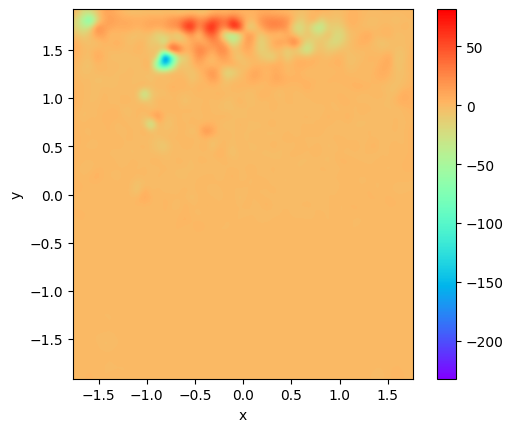

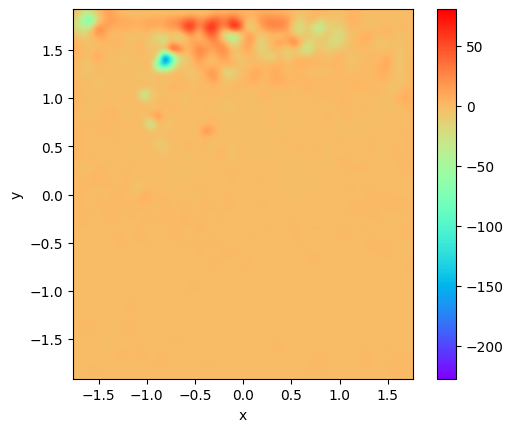

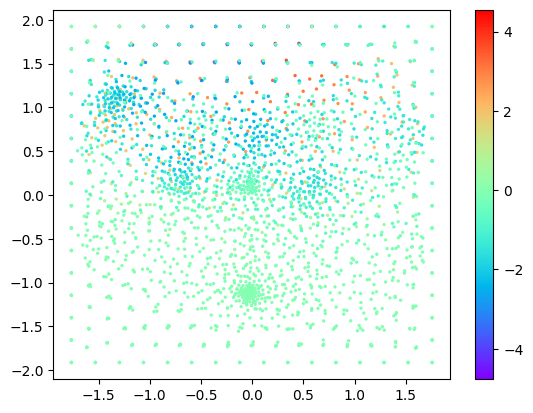

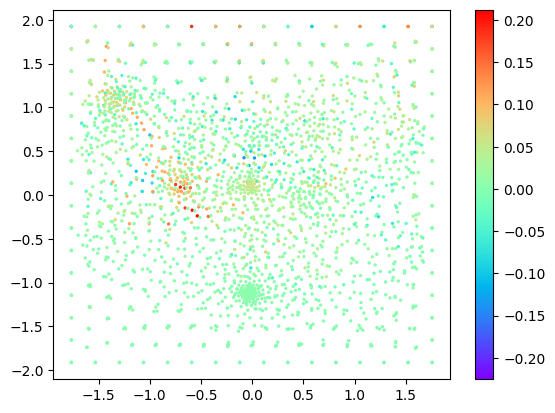

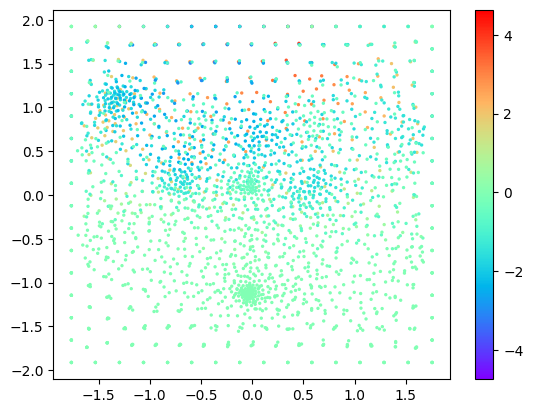

In [26]:
model.eval()
with torch.no_grad():
    #### test single case
    idx = 7
    g, u_p, g_u =  list(iter(test_loader))[idx]
    model = model.to("cpu")
    # u_p = u_p.unsqueeze(0)      ### test if necessary
    out = model(g, u_p, g_u)

    x, y = g.ndata['x'][:,0].cpu().numpy(), g.ndata['x'][:,1].cpu().numpy()
    pred = out[:,0].squeeze().cpu().numpy()
    target =g.ndata['y'][:,0].squeeze().cpu().numpy()
    err = pred - target
    print(pred)
    print(target)
    print(err)
    print(np.linalg.norm(err)/np.linalg.norm(target))
    
    #### choose one to visualize
    cm = plt.cm.get_cmap('rainbow')

    plot_heatmap(x, y, pred,cmap=cm,show=True)
    plot_heatmap(x, y, target,cmap=cm,show=True)


    plt.figure()
    plt.scatter(x, y, c=pred, cmap=cm,s=2)
    plt.colorbar()
    plt.show()
    plt.figure()
    plt.scatter(x, y, c=err, cmap=cm,s=2)
    plt.colorbar()

    plt.show()
    plt.scatter(x, y, c=target, s=2,cmap=cm)
    plt.colorbar()
    plt.show()